In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [3]:
def trend(time, slope=0):
    return slope * time

In [4]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

In [5]:
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [6]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [7]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [8]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [9]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [13]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [15]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 14ms/step - loss: 21.5167 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 21.1522 - mae: 21.6444
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 20.7302 - mae: 21.2236
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 20.2834 - mae: 20.7757
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 19.7897 - mae: 20.2855
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 19.1782 - mae: 19.6696
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 18.2410 - mae: 18.7333
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 17.4825 - mae: 17.9748
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 17.1597 - mae: 17.6529
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 16.8547 - mae: 17.3463
Epoch 11/100
31/31 [=========

31/31 [==============================] - ETA: 0s - loss: 6.5542 - mae: 7.038 - 0s 11ms/step - loss: 6.5542 - mae: 7.0384
Epoch 86/100
31/31 [==============================] - 0s 12ms/step - loss: 7.0101 - mae: 7.4949
Epoch 87/100
31/31 [==============================] - 0s 12ms/step - loss: 6.6498 - mae: 7.1338
Epoch 88/100
31/31 [==============================] - 0s 11ms/step - loss: 8.1959 - mae: 8.6816
Epoch 89/100
31/31 [==============================] - 0s 13ms/step - loss: 8.8122 - mae: 9.3028
Epoch 90/100
31/31 [==============================] - 0s 12ms/step - loss: 7.8979 - mae: 8.3864
Epoch 91/100
31/31 [==============================] - 0s 12ms/step - loss: 7.4111 - mae: 7.8956
Epoch 92/100
31/31 [==============================] - 0s 11ms/step - loss: 6.4151 - mae: 6.8966
Epoch 93/100
31/31 [==============================] - 0s 11ms/step - loss: 6.6464 - mae: 7.1323
Epoch 94/100
31/31 [==============================] - 0s 11ms/step - loss: 11.8256 - mae: 12.3184
Epoch 95/100


(1e-08, 0.0001, 0.0, 30.0)

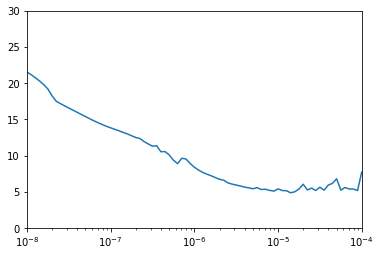

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

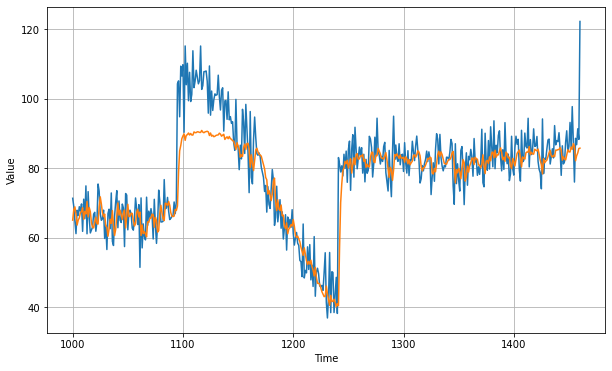

In [18]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.6518984

<Figure size 432x288 with 0 Axes>

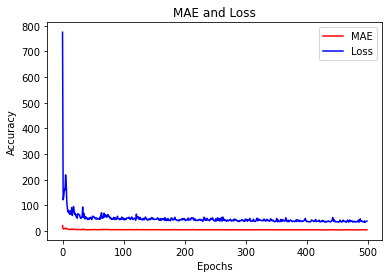

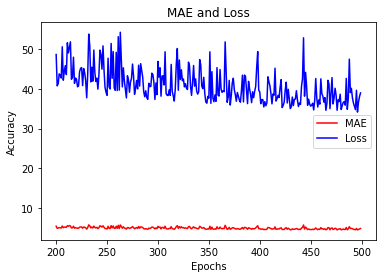

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [21]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [22]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 20ms/step - loss: 755.7013
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 152.7785
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 97.9761
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 83.2915
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 78.2600
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 73.4347
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 67.8632
Epoch 8/100
31/31 [==============================] - 1s 17ms/step - loss: 74.5354
Epoch 9/100
31/31 [==============================] - 1s 18ms/step - loss: 73.1458
Epoch 10/100
31/31 [==============================] - 1s 21ms/step - loss: 63.4809
Epoch 11/100
31/31 [==============================] - 1s 24ms/step - loss: 60.9757
Epoch 12/100
31/31 [==============================] - 1s 19ms/step - loss: 57.7044
Epoch 13/10

31/31 [==============================] - 1s 20ms/step - loss: 45.3499
Epoch 100/100
31/31 [==============================] - 1s 18ms/step - loss: 46.9555
